In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

In [ ]:
text = open('/content/input.txt','r').read()

vocab = sorted(list((set(text))))
idx_to_ch = {i:ch for i, ch in enumerate(vocab)}
ch_to_idx = {ch:i for i, ch in enumerate(vocab)}

In [ ]:
print(vocab)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
print(text[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [ ]:
def encode(txt):
  return([ch_to_idx[t] for t in txt])

def decode(lst):
  return ''.join([idx_to_ch[t] for t in lst])

In [ ]:
encode("app")

[39, 54, 54]

In [ ]:
decode([39, 54, 54])

'app'

In [ ]:
dataset = torch.tensor(encode(text), dtype = torch.int8)
dataset.shape

torch.Size([1115394])

In [ ]:
def get_batches(data, split, batch_size, context_window):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    batch_data = train

    if split == 'val':
        batch_data = val

    if split == 'test':
        batch_data = test

    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i : i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

In [ ]:
xs, ys = get_batches(dataset, 'train', 8, 16)

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[('e,\nAnd the gods ', ',\nAnd the gods d'),
 ('halt awake,\nShal', 'alt awake,\nShall'),
 ('uld accuse mysel', 'ld accuse myself'),
 ('at thou wouldst ', 't thou wouldst d'),
 ('Y:\nCourageous Ri', ':\nCourageous Ric'),
 ('anish thee,\nBut ', 'nish thee,\nBut t'),
 ('rt and nature,\nO', 't and nature,\nOn'),
 ('yes shall never ', 'es shall never c')]

In [ ]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
    'batch_size': 8,
    'context_window': 16
}

In [ ]:
@torch.no_grad()
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [ ]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        a = self.linear(x)
        logits = F.softmax(a, dim=-1)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

MASTER_CONFIG.update({
    'd_model': 128,
})
model = SimpleBrokenModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)

model params: 33217


model params: 33217
validation loss:  3.9585975885391234


<Axes: >

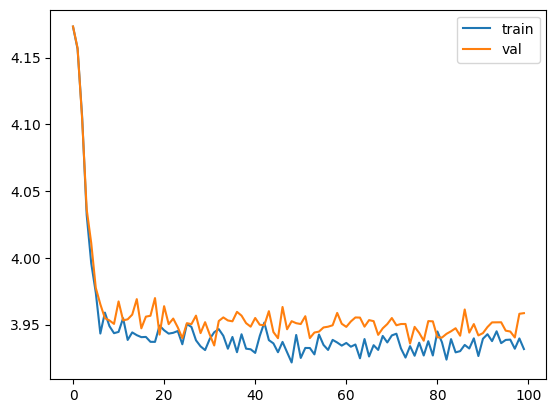

In [ ]:
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 10,
    'batch_size': 32,
})
model = SimpleBrokenModel(MASTER_CONFIG)

optimizer = torch.optim.Adam(
    model.parameters(),
)

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer)

model params: 33217
validation loss:  2.513208031654358


<Axes: >

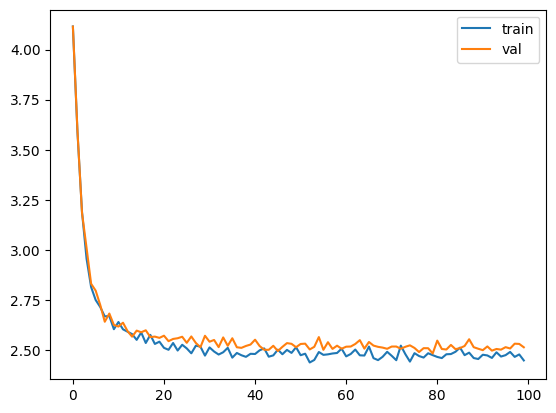

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [ ]:
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[:, -1, :]
        p = F.softmax(last_time_step_logits, dim=-1)
        idx_next = torch.multinomial(
            p, num_samples=1
        )
        idx = torch.cat([idx, idx_next], dim=-1)
    return [decode(x) for x in idx.tolist()]

generate(model)

['\n\n\nTomuger\nFrponss\nADit os orer',
 '\nW:\nin te.\nS:\nMy d heve blf ol ',
 '\nThind,\nIIfour cere e sher t mo',
 '\nCa me,\nMBOFed.\nt tingh tour et',
 '\nTHERIn therdomars tcrveitinace']

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

config = {
    'batch_size': 5,
    'context_window': 11,
    'd_model': 13,
}
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
m = RMSNorm((config['context_window'], config['d_model']))
g = m(batch)
print(g.shape)

torch.Size([5, 11, 13])


model params: 35265
validation loss:  2.5088326215744017


<Axes: >

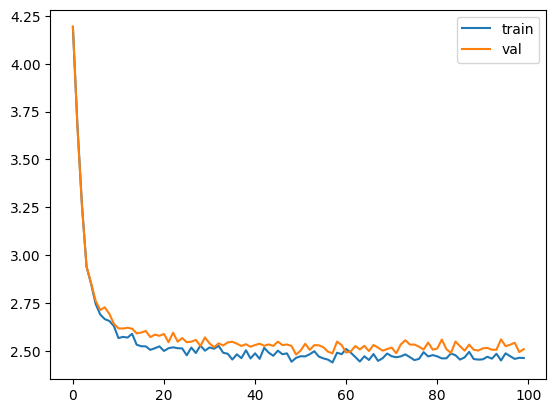

In [ ]:
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x) # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel_RMS(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [ ]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

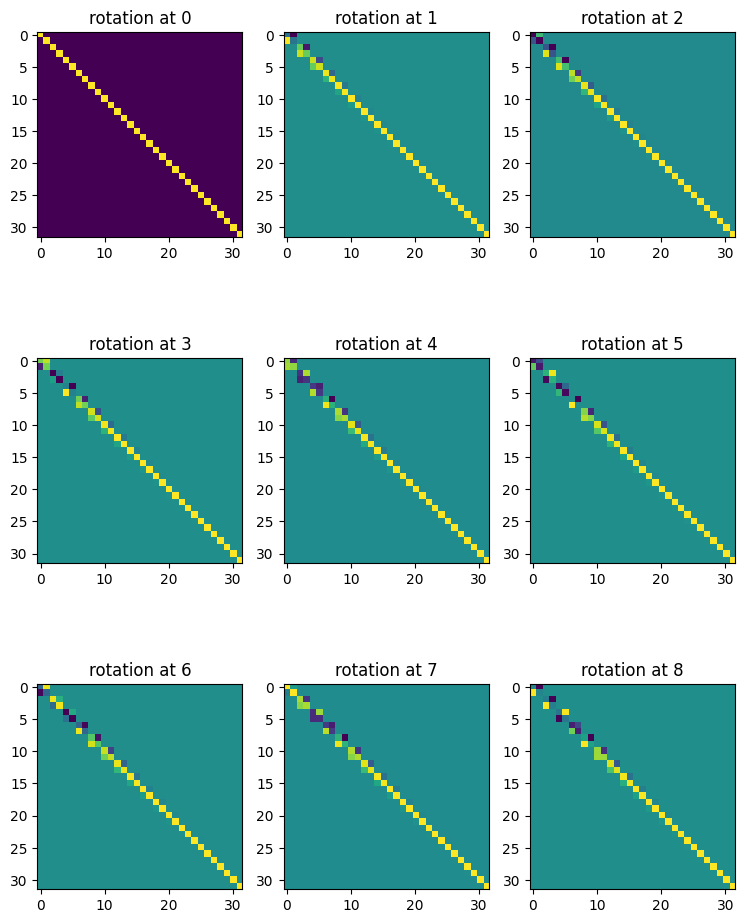

In [ ]:
K = 3
config = {
    'batch_size': 10,
    'd_model': 32,
    'n_heads': 8,
    'context_window': K**2,
}
batch = torch.randn(1, config['context_window'], config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

In [ ]:
config = {
    'd_model': 128,
    'context_window': 16,
}

R = get_rotary_matrix(config['context_window'], config['d_model'])
x = torch.randn(config['d_model'])
y = torch.randn(config['d_model'])

m = 3
n = 13

x_m = R[m,:,:] @ x
x_n = R[n,:,:] @ y

assert torch.isclose(x_m @ x_n, x @ R[n-m,:,:] @ y)

In [ ]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated,k_rotated,v,dropout_p =.1
        )

        if return_attn_weights:
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d)
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations

layer = RoPEAttentionHead(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

In [ ]:
class RoPEMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEMultiheadAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output = layer(batch)
output.shape

torch.Size([32, 16, 128])

model params: 559681
validation loss:  0.15031162202358245


<Axes: >

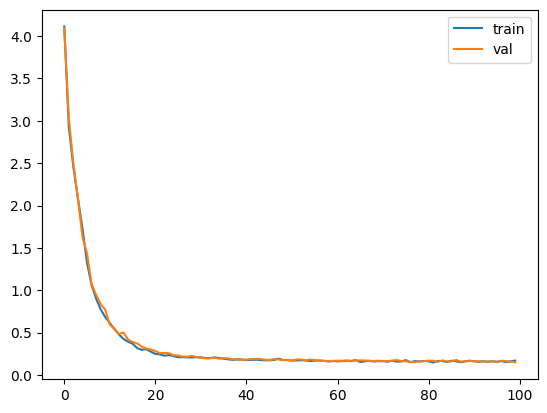

In [ ]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [ ]:
generate(model, config=MASTER_CONFIG)

['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n']

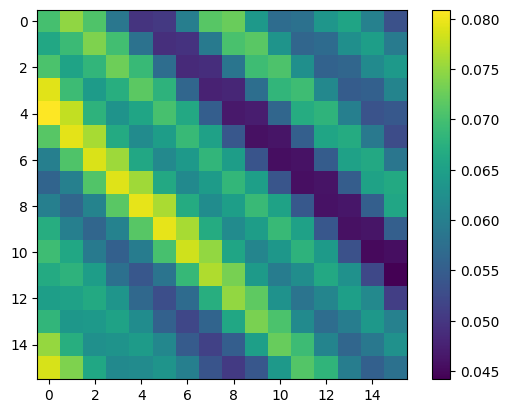

In [ ]:
MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEAttentionHead(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy(), interpolation='nearest')
plt.colorbar()

In [ ]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated,k_rotated,v,dropout_p =.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m,m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations

layer = RoPEMaskedAttentionHead(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

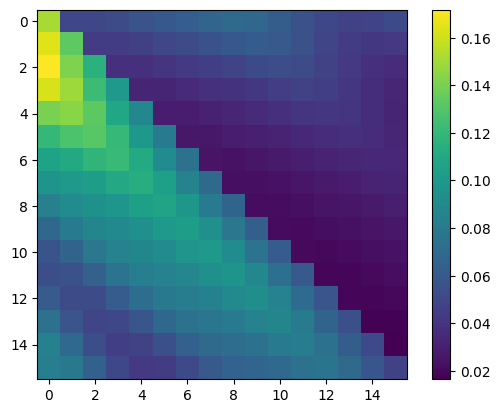

In [ ]:
layer = RoPEMaskedAttentionHead(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy())
plt.colorbar()

In [ ]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEMultiheadAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output = layer(batch)
output.shape

torch.Size([32, 16, 128])

model params: 559681
validation loss:  2.1270246624946596


<Axes: >

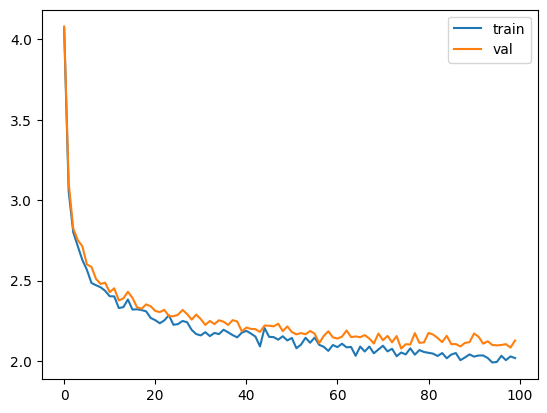

In [ ]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

validation loss:  1.9207247972488404


<Axes: >

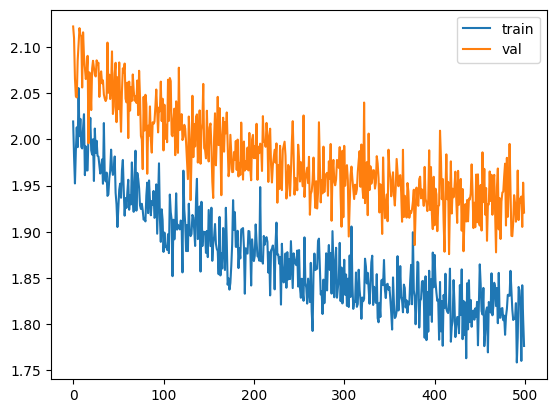

In [ ]:
MASTER_CONFIG.update({
    "epochs": 5000,
    "log_interval": 10,
})
train(model, optimizer)

In [ ]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

model params: 592706
validation loss:  1.9239000916481017


<Axes: >

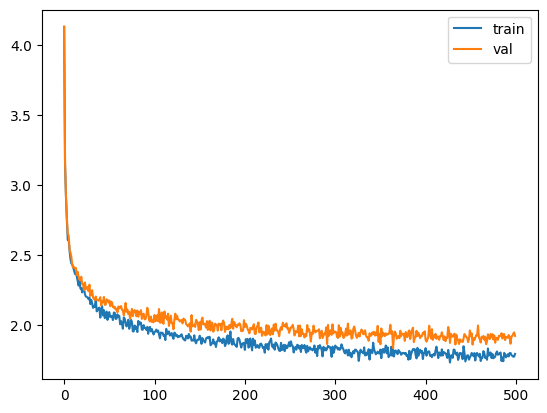

In [ ]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [ ]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))

        self.attention = RoPEMaskedMultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feedforward(x)
        return x

In [ ]:
block = LlamaBlock(MASTER_CONFIG)
block(torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']));

model params: 2370246
validation loss:  1.5491365551948548


<Axes: >

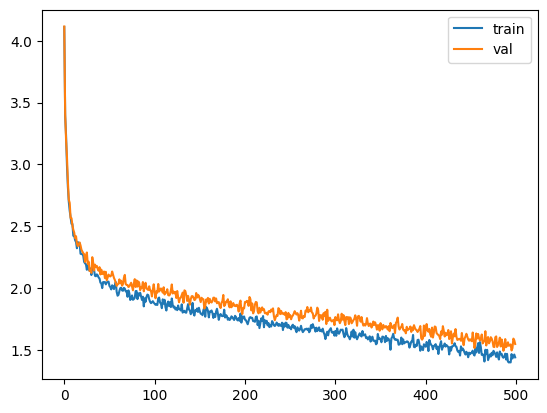

In [ ]:
from collections import OrderedDict

MASTER_CONFIG.update({
    'n_layers': 4,
})
class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG)

validation loss:  1.0726014852523804


<Axes: >

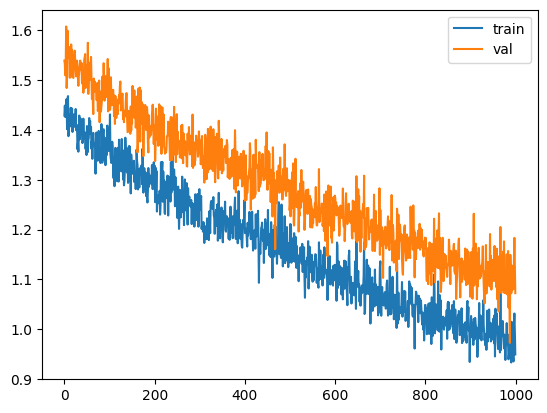

In [39]:
MASTER_CONFIG.update({
    'epochs': 10000,
})
train(llama, optimizer, scheduler=None, config=MASTER_CONFIG)

In [43]:
print(generate(llama, MASTER_CONFIG, 500)[0])


The made thist thing old all do, rate, thusb, so, rest pat mosty-uainous eddly, orthy madson:
You fort load that pleases for all!
Their dokes not you.
Frightle sisprayon, poor use goodes nor or arvopied; with thind surficious not will.e fhat's beathen yours siledent;
And ofsorved: endes love to ither,
Than mader. But slave
Cothal faul tismony thou, our ays!
Who buckest the mornotles;
Do his swoldy.
JULIET:
I' my with my more atch cotfuning crother injur's no; to modd falbisence at mayss
Oldieste


In [42]:
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = llama(xs, ys)

print(loss)

tensor(1.2281, grad_fn=<NllLossBackward0>)
